# Depresión en Reddit

## Introducción a la problemática

Actualmente hay una creciente tendencia a detectar de manera temprana problemas de salud mental en los usuarios de las redes sociales, éstas han tenido un impacto negativo en la salud mental de adolescentes y adultos jóvenes (https://www.cureus.com/articles/109723-reviewing-the-impact-of-social-media-on-the-mental-health-of-adolescents-and-young-adults), y cada vez son más los esfuerzos que hacen las compañías detrás de las redes sociales para actuar de manera preventiva e incluso brindando apoyo. Es por ello, que el caso de uso que se abarca en este documento va en relación con esta problemática. Lo que se busca con este caso de uso en particular es lograr la detección de comportamientos o tendencias a la depresión en términos de salud mental, por medio del análisis del contenido de posts de Reddit. Luego con esta información sería posible realizar proyectos preventivos o incluso brindar ayuda.

Para lograr llevar a cabo este caso de uso, se hará uso del siguiente dataset:
https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

Éste dataset contiene 7731 registros a la fecha y está dividido en dos columnas
* El texto `clean_text`
* La etiqueta `is_depression`

Para cada registro: ` clean_text ` es la extracción del contenido de un post de Reddit, e ` is_depression ` es su clasificación manual sobre si tiene tendencia `1` o no `0` a la depresión.

Este dataset además ya ha sido pre-procesado por lo que está relativamente limpio y podría ser usado así sin mayores cambios para entrenar un modelo de predicción, pero aun así se hará de nuevo todo el proceso de pre-procesamiento de texto con el objetivo de asegurar que los datos estén completamente listos y además porque se necesita de este proceso para preparar los datos reales con los que se va a poner a prueba el modelo.

Un ejemplo de cómo se ven los registros del dataset es el siguiente:

In [1]:
import pandas as pd

data = pd.read_csv("../input/depression-reddit-cleaned/depression_dataset_reddit_cleaned.csv")
data.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


Entonces esto permite crear y entrenar un modelo de Machine Learning que dado el contenido de un post de Reddit se pueda clasificar si tiene tendencia a la depresión o no.

El dataset no viene dividido en `test`, `train` y `dev` por lo que nos toca hacer la separación de datos.

## Problema de analítica que se desea resolver con el caso de uso.

Este tipo de problemas de clasificación de texto tienen varios problemas:
* La cantidad de variables.
* La diversidad de métodos que existen para abordar el problema de clasificación.
* La extracción del texto para poner a prueba el modelo.
* El resultado de la predicción.

La cantidad de variables en un problema de clasificación de texto pueden ser tantas como la cantidad de palabras únicas del texto con más palabras únicas en el dataset, por lo que se podría tener un array con decenas de miles de variables lo que haría los costos y los tiempos de entrenamiento muy altos, por lo que se deben reducir la cantidad de variables a un número considerablemente más pequeño.

La diversidad de métodos que existen para abordar un problema de clasificación de texto son muchos, por lo que se invirtió tiempo en estudiar cuales de ellos dan buenos resultados y se eligieron dos en un tiempo razonable para lograr tener la solución lista.

La extracción del texto para poner a prueba el modelo debe ser extraído haciendo uso de técnicas de `web scraping` ya que la idea es que el input de nuestro modelo sea el contenido de un post de Reddit, y para ello necesitamos encontrar alguna manera de hacer esto dentro de este mismo notebook.

El resultado de la predicción es nuestro último problema, se pondrá a prueba el modelo con casos de la vida real y evaluaremos que tan efectivos son nuestros modelos y `se elegirá el que se considere que tiene mejores resultados`.

## Tecnologías a utilizar en el caso de uso.

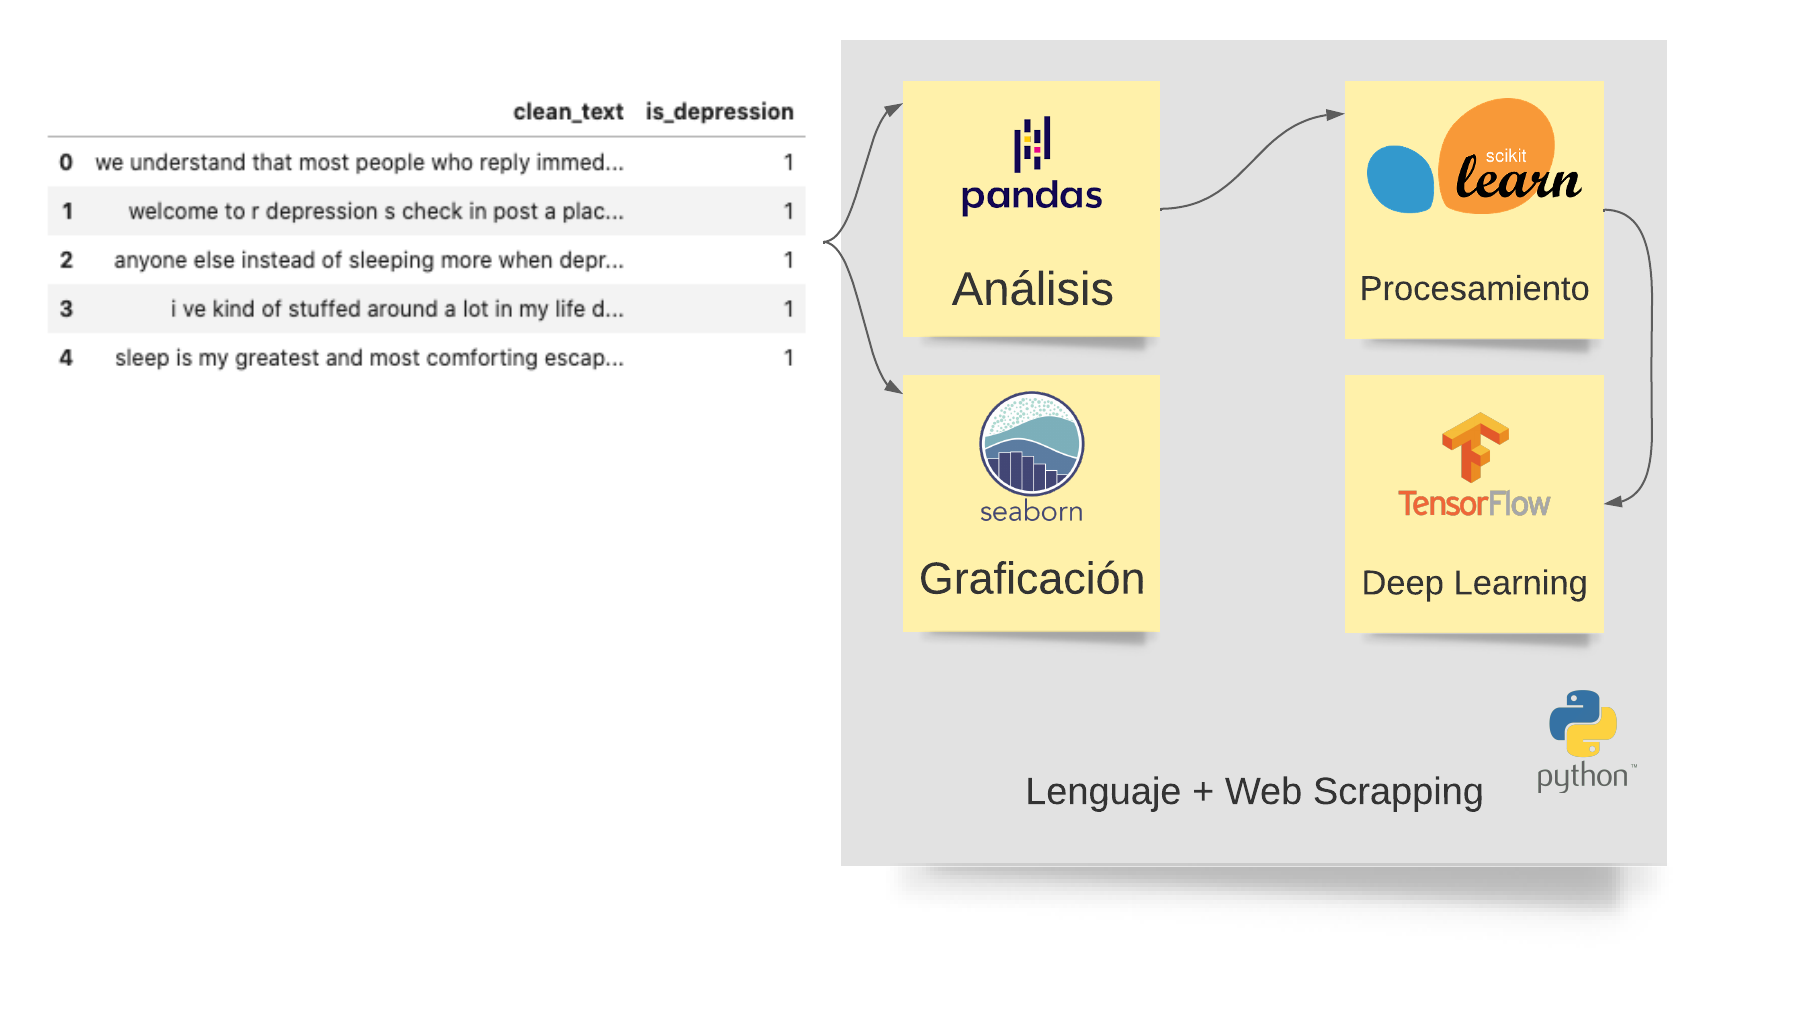

In [2]:
from IPython.display import Image
Image("../input/arquitectura/Ideation.png")

Lo primero que se hará va a ser un análisis de los datos previo a cualquier procesamiento, se estudiará el dataset y se extraerá información que pueda ser valiosa para el momento del procesamiento.

In [3]:
data.describe()

,is_depression
count,7731.000000
mean,0.495537
std,0.500012
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Cómo se había dicho, la cantidad de registros son 7731 y ya que los únicos valores posibles del dataset para la columna `is_depression` son `1` y `0`, que la media sea cercana a `0.5` ya nos indica que hay un buen balance en la clasificación manual de los datos.

Se importa la librería `seaborn` que nos permite ver los datos de manera gráfica.

<AxesSubplot:xlabel='is_depression', ylabel='count'>

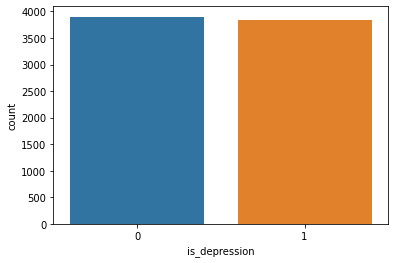

In [4]:
import seaborn as sns

# Gráfico que nos permite ver la distribución de los datos
sns.countplot(data=data, x='is_depression')

Como se puede observar, los datos están balanceados, lo que significa que hay una representación equitativa entre los posts que están catalogados con `1 ` y con `0 `

## Procesamiento de datos a realizar

Ya que este caso de uso está pensado para ser ejecutado en un entorno virtual, se hará uso de Kaggle para su desarrollo y ejecución.
El entorno fue elegido por su facilidad en la importación del dataset y porque además queda público para que pueda ser replicado por otras personas de manera fácil.

Comenzaremos entonces con una explicación acerca de un proceso para preparar los datos para su transformación.

### Lematizar
Lematizar es un proceso lingüístico que consiste en hallar el lema de una palabra dada en forma flexionada (plural, conjugada, etc.…). El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.
https://es.wikipedia.org/wiki/Lematizaci%C3%B3n

Ejemplos de lematización:

*   Cortamos: `Cortar`
*   Cociendo: `Cocer`
*   Corre: `Correr`

El proceso de lematizar es ampliamente usado en sistemas de recuperación como motores de búsqueda e indexación compacta.

#### Wordnet

`Wordnet` es una base de datos léxica; es larga, gratuita, pública y disponible para el lenguaje Ingles con el objetivo de establecer relaciones semánticas estructuradas entre palabras. Ofrece herramientas de lematización y es una de las primeras bases de datos que fueron creadas para este uso y también una de las más usadas.

#### NLTK

`NLTK` es una librería de Python que ofrece una interfaz a ` Wordnet `, primero se debe descargar la base de datos antes de usarla.

In [5]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lm = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


También se va a hacer uso de la librería `re` que nos permite operar fácilmente con expresiones regulares.

In [6]:
import re

Ahora se aplicarán ciertas transformaciones a cada uno de los textos, como remover signos no alfabéticos, convertir nuestro texto en una lista de palabras en un proceso llamado `Tokenization `, y luego lematizar cada una de las palabras para luego unir de nuevo todo el texto ya lematizado. Se encapsulará este proceso en una función para poder ser usada luego con los datos reales.

In [7]:
def tokenize(data):
    posts = []
    for post in data['clean_text']:
        # Remover todos los signos no alfabéticos
        post = re.sub("[^a-zA-Z]", " ", post)

        # Tokenizar cada texto de cada post en palabras.
        post = nltk.word_tokenize(post, language="english")

        # Lematizar cada una de las palabras.
        post = [lm.lemmatize(word) for word in post]

        # Unir de nuevo las palabras en un único string.
        post = " ".join(post)

        posts.append(post)
    return posts

posts = tokenize(data)

### Vectorización

Ahora, el proceso más importante para lograr que un modelo de Deep Learning pueda procesar los textos es convirtiéndolos en tipos de datos que las máquinas si entienden; números. Hay varias maneras de llevar esto a cabo, esta vez se usará un meto que separa todas las `palabras únicas` de todo el dataset y las convierta en columnas en un proceso llamado `Vectorización`, y luego asigna un valor a cada columna igual a la `cantidad de ocurrencias` que esa palabra tiene para cada post en cada registro. Cómo se dijo al principio, uno de los problemas a solucionar es la cantidad de variables que se generan cuando se trabaja con texto en problemas de clasificación, y es precisamente por este proceso que este problema surge, la cantidad de variables pasó de ser una `un texto por registro` a miles `cada palabra única ahora es una variable`, entonces veremos más adelante cómo podemos comenzar a reducir la cantidad de variables.

Adicionalmente a esto, separar las palabras en columnas de esta manera nos obliga a tratar las variables de manera equitativa e independiente obligando a nuestros modelos a encontrar las relaciones entre ellas de manera automática.

### Stop Words

El primer proceso que se hará en nuestro esfuerzo por hacer una buena reducción de dimensionalidad es la de eliminar de los posts las palabras vacías (`Stop_words`), palabras que por lo general son conectores lingüísticos pero que no aportan mucho significado a una frase o al texto en general.

### CountVectorizer

Ahora lo que se hará será reducir significativamente la cantidad de variables, se elegirán solo las palabras de todo nuestro dataset que más se repitan, y queremos hacer esto porque las palabras que aparecen muy pocas veces no aportan mucha información para que nuestro modelo encuentre relaciones entre las palabras por lo que dicho de otra manera, vamos a descartar las palabras que menos aportan contexto a nuestro objetivo de clasificación, la cantidad de palabras a elegir es una cantidad muy subjetiva y la idea es ir jugando con valores para encontrar un buen equilibrio y al final tener modelo preciso. El valor elegido al final después de ejecutar iteraciones de prueba fue: `550`.

Esto visto de otra manera es como hacer un mapa de calor con todas las palabras de toda la base de datos y seleccionar solo el grupo en el que están concentradas la mayoría de las palabras, descartando palabras que solo se usaron una o muy pocas veces.

Este proceso de Vectorizar y Contar se realiza fácilmente con `Sklearn` y su clase `CountVectorizer`.

Se importa la clase CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

Se definen las características de la vectorización, como la cantidad de palabras a extraer y si deseamos remover las palabras vacías.

In [9]:
count = CountVectorizer(stop_words = 'english', max_features = 550, )

Se le indica a la instancia de clase que aprenda el vocabulario de todo el diccionario de palabras del dataset de entrenamiento.

In [10]:
count.fit(posts)

CountVectorizer(max_features=550, stop_words='english')

Y por último se transforma nuestro dataset de entrenamiento al esquema aprendido anteriormente.
Además de esto lo transformamos en un array.

In [11]:
array = count.transform(posts).toarray()

Se van a separar los para entrenar al modelo en 2 variables:
Las características `X ` y los objetivos `y `

In [12]:
X = array
y = data['is_depression'].values

### sklearn

Haciendo uso de `train_test_split` se separan los datos en 2 grupos;
El primer grupo de entrenamiento, y el segundo grupo de prueba, esta separación cómo se vio durante el máster es comúnmente 70% vs 30%, sin embargo, también es una relación subjetiva y es un valor con el que se puede jugar un poco para tener un modelo bien entrenado.

También se usa el parámetro `stratify=y` para decirle al método que se quiere que la porción de datos de entrenamiento tome igual representación de todos los posibles valores de `y` (`0, 1`)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y
)

A partir de este punto se termina el proceso de Pre-procesamiento de datos,
Este proceso es indispensable e independiente del predictor o los métodos con los que luego se entrene el modelo, por lo que los datos tal y como los tenemos acá pueden ser enviados a diferentes modelos predictivos.

## Definición y explicación de los procedimientos/algoritmos seleccionados.

Para abarcar el segundo de los problemas que es 'la diversidad de métodos que existen para abordar el problema de clasificación', se van a entrenar dos modelos diferentes con dos técnicas diferentes para luego compararlos y elegir uno basado en los resultados.

•	El primero de los modelos será un clasificador gaussiano que está fundamentado en un teorema probabilístico llamado `Teorema de Bayes`, que se explicará a continuación, la tecnología a usar será `sklearn`.

•	El segundo de los modelos será una red neuronal que se diseñará con el objetivo de clasificar categorías, la tecnología a usar será `tensorflow`.

## Modelo 1 - `Gaussian Naive Bayes`

#### El teorema de Bayes
El teorema de Bayes, en la teoría de la probabilidad, es una proposición planteada por el matemático inglés Thomas Bayes y publicada póstumamente en 1763, que expresa la probabilidad condicional de un evento aleatorio `A` dado `B` en términos de la distribución de probabilidad condicional del evento `B` dado `A` y la distribución de probabilidad marginal de solo `A`.
https://es.wikipedia.org/wiki/Teorema_de_Bayes

#### Gaussian Naive Bayes (Clasificador bayesiano ingenuo)
Es un modelo de clasificación gaussiano básico pero efectivo en Machine Learning que está fundamentado en el teorema de Bayes.
Este método asume que las características contribuyen de manera equitativa e independiente a la selección de un valor de salida o resultado.
Aunque esta característica haría el modelo inviable en circunstancias del mundo real, esta suposición produce resultados muy satisfactorios y es comúnmente usado en clasificación y categorización de texto.

#### Tipos de Clasificadores Bayesianos
##### Gaussian Naive Bayes
Empleado cuando las características son continuas y se espera que sigan una distribución Gaussiana.
##### Bernoulli Naive Bayes
Empleado cuando las características son boléanos y se espera que sigan una distribución de Bernoulli
##### Miltinominal Naive Bayes
Hace uso de distribución Multinomial y también es usado para resolver problemas de clasificación de texto o documentos.


A continuación, se va a importar la clase `GaussianNB`, proveída por Sklearn. Esta es una interfaz al clasificador del que se habló anteriormente y es la que se usará para entrenar el primero modelo.

In [14]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

Se procede a entrenar el modelo con el uso del método `fit`

In [15]:
# Entrenamiento del modelo
nb.fit(X_train, y_train)

GaussianNB()

Luego se quiere saber que tan preciso es el modelo y para ellos se pone a prueba con los datos que se reservaron para la etapa de validación.

In [16]:
# Evaluar el modelo, con los datos test
nb.score(X_test, y_test)

0.9388714733542319

Cómo se ve con este método, se logró una precisión por encima del 93% que es, a mi parecer y luego de muchas iteraciones, bastante sorprendente.

Ahora se muestran los resultados del predictor usando una matriz de confusión, que nos muestra: 
*   Verdaderos Positivos (arriba izquierda)
*   Falsos Positivos (arriba derecha)
*   Falsos Negativos (abajo izquierda)
*   Verdaderos Negativos (abajo derecha)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


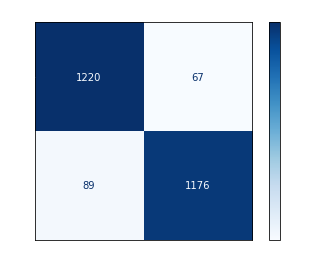

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1287
           1       0.95      0.93      0.94      1265

    accuracy                           0.94      2552
   macro avg       0.94      0.94      0.94      2552
weighted avg       0.94      0.94      0.94      2552



In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,nb.predict(X_test))
 
color = 'white'
matrix = plot_confusion_matrix(nb, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

from sklearn.metrics import classification_report
 
print(classification_report(y_test, nb.predict(X_test)))

## Modelo 2 - `Deep Learning with Keras`

A continuación, se mostrará el desarrollo de una red neuronal usando Keras con la que se espera obtener un resultado similar al obtenido usando el Clasificador de Bayes.

Se usará la misma base de datos, y cómo se mencionó anteriormente el pre-procesamiento de los datos será el mismo también, por lo que se va a obviar esa parte y usar los mismos datos pre-procesados ya que nos sirven bien para este modelo.

La manera más rápida de crear un modelo con Keras es usando `Keras.Sequential`, que crea una red neuronal como una pila de capas, es por esto que es indispensable importar `keras` y su respectiva clase `layers`

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

Se definirá un modelo que acepte `550` características de entrada, que son las mismas `550` con las que nos quedamos de nuestro dataset. Esto significa que, si decidimos cambiar la cantidad de variables en nuestro proceso de vectorización, también debemos cambiar nuestro valor de `input_shape`.

Este es un modelo que tendrá tres capas densas, dos con 100 neuronas y la última que debe tener una sola neurona, además de un par de capas intermedias más que nos permitirán tener un modelo que aprenda mejor.

Se definirá que el modelo en su primera capa cuente con `100` neuronas, este número es, al igual que la cantidad de variables, un número muy subjetivo y es un valor con el que hay que jugar para encontrar la mejor combinación y el modelo no sea muy complejo o muy simple y no logre aprender.

Otra característica importante de la red neuronal es la función de activación, se usará `relu` ya que funciona muy bien para modelos de regresión como de clasificación.

Las siguientes capas que se añadieron a nuestro modelo son las capas de `BatchNormalization` que ayudan a nuestro modelo a corregir problemas de entrenamiento si éste está lento o inestable, las capas de `BatchNormalization` son más efectivas cuando los datos no están normalizados, y lo que hace la capa es normalizar los outputs de las neuronas con sus propios valores de Media y Desviación Estándar, para luego transformar los datos en una nueva escala que sea más amigable para la red, con la data que se está trabajando se tiene la ventaja de que los datos están normalizados, por eso se decidió comentar estas capas al ver que realmente no aportaba mejores resultados.

Por último, se añadirán capas `Dropout` antes de las dos últimas capas densas, esto con el objetivo de corregir el overfitting impidiendo a la red que aprenda atajos y anulando una fracción de las unidades de entrada de la siguiente capa, este es un valor que va de `0` a `1` y al igual que con otros valores es de jugar con ellos para encontrar un buen balance.

En las primeras iteraciones que se hicieron, se usaron `250` neuronas, pero tuve la sensación de que la red estaba siendo muy compleja, y se decidió reducir la cantidad de neuronas por capas y definir un `Dropout` más alto (`0.5`), un poco jugando con los valores, y un poco obligando a la red a iterar más tratando de que buscara más relaciones ocultas entre las variables. Más adelante se ve el resultado del tiempo invertido en la exploración de los valores en la red.

In [19]:
# Definición del Modelo
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[550]),

    # layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(100, activation='relu'),

    # layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid')
])

2022-11-02 20:58:19.632761: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Ahora es momento de definir los que serán los atributos del compilador: la función de perdida, el optimizador y las métricas.

### Función de Perdida

Se necesita medir la diferencia entre el valor objetivo y el valor que el modelo predice, depende del modelo que estemos entrenando existen diferentes funciones de perdida, para problemas de regresión en los que se busca predecir un valor numérico es común usar la función de perdida `MAE (mean absolute error)` que mide la disparidad del objetivo verdadero `y_true` por una diferencia absoluta `abs(y_true - y_pred)`.

Para problemas de clasificación binaria en donde los posibles valores de salida son solo `1`, o `0` se usa `binary_crossentropy`, la idea es lograr predecir con una probabilidad de 1 la clase correcta. Y mientras más baja sea la probabilidad de identificar la clase correcta, mayor será la pérdida.

Para añadir la función de perdida al modelo, se hace uso del método `Compile` del modelo

### Optimizador

Con la función de pérdida se describió nuestro problema a resolver, pero ahora se le debe indicar al modelo cómo resolverlo, y este es el trabajo del optimizador; un algoritmo iterativo que ajusta los pesos y minimiza la pérdida y entrena a la red en múltiples pasos, cada uno de estos pasos se ve de la siguiente manera:

* Se generan pesos aleatorios de entrenamiento para hacer predicciones
* Se mide la pérdida entre la predicción y los valores reales
* Se ajustan los pesos en una dirección que hace que la perdida sea menor

Estos pasos se hacen una y otra vez hasta que la perdida sea lo más pequeña posible (tanto como queramos) o hasta que la cantidad de iteraciones llegue a su fin.

### Métricas

Las métricas son una función usada para juzgar el rendimiento de nuestro modelo, y ya que nuestra red está diseñada para resolver problemas de clasificación binaria, usaremos `binary_accuracy`

In [20]:
# Compilar el Modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

### EarlyStopping
Las redes neuronales en general tienden a aprender ruido de los datos lo que puede hacer que nuestra función de perdida comience a registrar altos niveles de perdida luego de que ya estaban en lo más bajo posible, para prevenir esto podemos agregar una función de frenado temprano que detiene el aprendizaje de la red cuando parece que la validación de pérdida no está decreciendo más.
En los parámetros del `EarlyStopping` tenemos:
* patience: la cantidad de veces que esperaremos antes de parar.
* min_delta: la mínima cantidad de mejora aceptada como cambio.
* restore_best_weights: Devuelve a la red al momento en que estuvo en su mejor punto.

In [21]:
# Definición de la función EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Por último se entrena nuestra red, se le pasan por parámetros los datos de entrenamiento y los datos de validación, la red entonces comenzará a iterar con los datos de entrenamiento hasta una cantidad total de 100 veces (epochs) y se detendrá después de esas 100 veces o cuando la función de `EarlyStopping` lo haga porque encontró que la red ya no estaba aprendiendo más.

In [22]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)

2022-11-02 20:58:19.818431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Para ver los resultados de una manera gráfica podemos llamar los datos almacenados por la red al momento del entrenamiento, ver los niveles de perdida y los niveles de precisión es importante para hacernos una idea de la velocidad con la que la red aprende de los datos, además se puede ver claramente cuantos epochs le tomó a la red aprender de los datos (que en este caso son alrededor de 20 dependiendo de la ejecución y de los estados aleatorios originales de los pesos al momento de iniciar de entrenamiento).

<AxesSubplot:title={'center':'Accuracy'}>

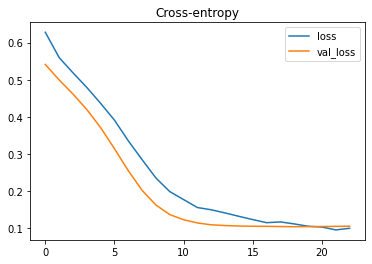

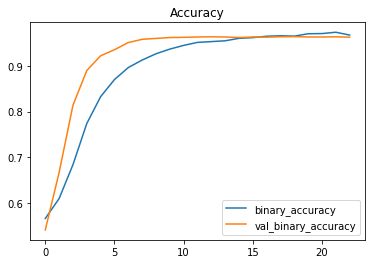

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [24]:
eval = model.evaluate(X_test, y_test)

80/80 [==============================] - 0s 1ms/step - loss: 0.1045 - binary_accuracy: 0.9636


Se obtuvo un resultado bastante mejor de lo esperado, y mis interpretaciones personales son que estos resultados son producto del buen pre-procesamiento de los datos, este fue uno de los mejores resultados que pude obtener, con otras combinaciones de capas y neuronas, la cantidad de epochs no superaba las 10 iteraciones y la red realmente no aprendía mucho y se obtenía como máximo un `0.59` de precisión.

A continuación, se hace un ejercicio manual para poner a prueba el modelo ya entrenado, pero con datos `reales`.
Haciendo uso del método `transform` ajustamos una frase al formato que la red neuronal entiende, y entonces podemos hacer uso del método `predict` para evaluar la capacidad de la red de predecir un resultado. A partir de este punto se entiende que los resultados de la red están sujetos a la subjetividad con la que se clasificaron los textos en primer lugar además de la aleatoriedad de los textos seleccionados para ser clasificados. Por lo que es esperable que haya un sesgo, además de esto existe otro sesgo que es el de todos los datos que no se usaron porque hacían el esquema de los datos demasiado grandes y por ende un modelo más difícil de entrenar.

Con lo anterior claro, a continuación, se evidencia la red neuronal en funcionamiento:

In [25]:
new_df = pd.DataFrame({'clean_text': ["Life doesn't make any sense to me anymore"]})
new_post = count.transform(tokenize(new_df)).toarray()
resp = model.predict(new_post)[0][0]
resp

0.8345376

Como bien sabemos la red neuronal está entrenada para clasificar entre 2 categorías, la red nos devuelve es el valor correspondiente a la probabilidad de que la clase sea `0` o `1` por lo que debemos aplicar una función de activación para obtener el resultado final.
En este ejercicio se ve que la frase ingresada manualmente tiene una evaluación que lo ubica por encima del umbral de decisión `(0.5)`, en otras palabras, la red neuronal logró identificar que la frase contenida en el texto de entrada efectivamente tiene una tendencia o todo depresivos.

## Herramienta Python - Reddit

A continuación, se define una función que nos va a servir para poner a prueba nuestro modelo con información del mundo real.
La manera en que se construye esta clase es ajustando el texto entrante a las características del modelo, recordemos que nuestro esquema es un array de `550` palabras por lo que se debe decirle al vectorizador que al igual que como hizo con el dataset de entrenamiento, ajuste el texto entrante al esquema existente, de esta manera el modelo de predicción va a recibir un dato tal y como fueron los datos de entrenamiento y podrá hacer una predicción.

-- Importante -- 
Se ponen a prueba ambos modelos, el Gaussian Naive Bayes `(gnb)` y el de Deep Learning y Keras `(dlk)` para comparar resultados.

In [26]:
# Predicción usando GaussianNB
def predict(text, model_type):
    
    # Se crea un dataframe con la columna 'clean_text' y el valor correspondiente al texto entrante
    new_df = pd.DataFrame({'clean_text': [text]})
    
    # Se ajusta el dataframe al esquema mencionado anteriormente, además de ser pasado por la función 'tokenize'
    new_post = count.transform(tokenize(new_df)).toarray()
    
    if "gnb" == model_type:
        # Se imprime True o False dependiendo de si la predicción del modelo fue `1` o `0`
        print("Is_depression_gnb: True" if nb.predict(new_post)[0] else "Is_depression_gnb: False")
    elif "dlk" == model_type:
        # Se imprime True o False dependiendo de si la predicción del modelo fue `1` o `0`
        print("Is_depression_dlk: True" if model.predict(new_post)[0][0] >= 0.5 else "Is_depression_dlk: False")
        

## Web Scraping

A continuación, se hará uso de la librería `requests` para obtener datos reales de la `API` de reddit, se define una función para obtener los datos que recibe como parámetros el nombre del sub_reddit, el límite de posts que deseamos obtener, el marco de tiempo para el cual queremos hacer la búsqueda y el tipo de lista de la que se quieren obtener resultados, esta función retorna entonces un diccionario de datos con el contenido de la respuesta de la `API` de reddit.

In [27]:
import requests
from bs4 import BeautifulSoup
 
def get_reddit(sub_reddit,limit,time_frame,listing):
    try:
        base_url = f'https://www.reddit.com/r/{sub_reddit}/{listing}.json?limit={limit}&t={time_frame}'
        request = requests.get(base_url, headers = {'User-agent': 'yourbot'})
    except:
        print('An Error Occured')
    return request.json()

A continuación, se define una función que:
* Valida que los posts contengan texto en el contenido, ya que los posts que contienen solo imágenes no nos son útiles para poner a prueba nuestro modelo
* Envía el texto al método definido anteriormente para que sea evaluado por la red neuronal.
* Imprime en pantalla algunos saltos de línea para que sea visible cuando comienza y termina un post.

In [28]:
def get_reddit_posts(sub_reddit, limit, time_frame, listing):
    r = get_reddit(sub_reddit,limit,time_frame,listing)
    for r_post in r['data']['children']:
        r_post_text = r_post['data']['title'] + r_post['data']['selftext']
        if r_post_text != "":
            print(r_post_text)
            print("")
            predict(r_post_text, "gnb")
            predict(r_post_text, "dlk")
            print("___")
            print("___")

Por último, se llama la función con los parámetros que deseamos probar y se evidencian los resultados. En esta ocasión se decidió obtener datos del sub_reddit `Depression` que se asume contiene posts en los que su contenido de por sí, debería ser clasificado con tendencia o tonos depresivos.

In [29]:
get_reddit_posts(
    sub_reddit='Depression',
    limit=5,
    time_frame = 'day', #hour, day, week, month, year, all
    listing = 'new' # controversial, best, hot, new, random, rising, top
)

i really can’t take anything elsenothing has gone right for me and i don’t look forward to anything anymore i really don’t know how much longer i can home on. ive known people who have killed themselves and i know how much it hurts i don’t want to put anyone else through that but it can’t be much worse to what i’m feeling and i don’t know if that’s selfish but i have felt this way for so long just waiting for things to change and i know they won’t because i have no energy to change them so it feels like it would be easier to give up completely

Is_depression_gnb: True
Is_depression_dlk: True
___
___
Best Escapist games for extreme times? (PS5/4 &amp; Switch)When i’ve been at my absolute lowest i always end up getting lost in Skyrim, fallout 4 or subnautica for a month or 2 and actually feeling alive when i am. Currently at this point after losing my job while feeling trapped in a failing relationship with a very angry man (im completely safe, just really hoping he’ll get help or it has

Vemos que ambos modelos tienen una precisión bastante alta y logran clasificar con bastante precisión los textos del sub_reddit `Depression`.

A continuación se pondrá a prueba el modelo con datos de otro sub_reddit `(ShowerThoughts)`  en el que se asume que con tiene posts en los que su contenido de por sí, no debería ser clasificado con tendencia o tonos depresivos.

In [30]:
get_reddit_posts(
    sub_reddit='ShowerThoughts',
    limit=5,
    time_frame = 'all', #hour, day, week, month, year, all
    listing = 'best' # controversial, best, hot, new, random, rising, top
)

In the board game Clue, the killer must have left behind a messy crime scene if players can't tell if Mr. Boddy was shot, stabbed, strangled, or beaten.

Is_depression_gnb: False
Is_depression_dlk: False
___
___
Many men learned how to shave their face from their dad, most men had to figure out how to shave their balls by themselves

Is_depression_gnb: False
Is_depression_dlk: False
___
___
A positive thing about aging is that there is a higher and higher chance that someone has died that witnessed you do something embarrassing in the past and that memory is gone forever.

Is_depression_gnb: False
Is_depression_dlk: False
___
___
Cats are nowhere near as intelligent as humans yet it just feels like they know something we don’t

Is_depression_gnb: True
Is_depression_dlk: True
___
___
Probably more than one cook was executed because the food tester had an unknown allergy

Is_depression_gnb: False
Is_depression_dlk: False
___
___


Para este caso vemos cómo ambas redes parecen ser bastante consistentes en la clasificación del texto, en las pruebas que no quedaron registradas en este notebook se evidenció que la cantidad de falsos positivos es mucho mayor a la de falsos negativos, además que en general los verdaderos positivos y los verdaderos negativos son consistentes sobre todo en textos más largos.

## Conclusiones

Llegó la hora de definir cual modelo es mejor y porqué, personalmente me parece que entrenar los 2 modelos y compararlos fue una manera enriquecedora de entender la naturaleza de la clasificación de texto, ninguno de los dos modelos es perfecto, y ambos cometen errores, por supuesto los modelos podrían ser entrenados con muchos más datos y ajustar estos problemas, pero en general y comparando los resultados de ambos modelos se puede decir que ambos tienen un comportamiento bastante aceptable. Por lo general en el mundo real los modelos son entrenados con muchos más datos, por lo que los tiempos y capacidad de procesamiento son variables a tener en cuenta y eso fue algo que se trató de tener en cuenta acá incluso teniendo relativos pocos datos, pero para un ambiente real me parece que es más conveniente y más poderosa una red neuronal, la capacidad de poder recibir datos que no hayan sido normalizados y hacer uso de capas de normalización es un asset muy valioso, además de la flexibilidad que da poder jugar con la cantidad y diversidad de capas y la cantidad de neuronas. La decisión final entonces es elegir el modelo de Deep Learning con Keras como el más completo, versátil y fácil de entender, además de que también arrojó un mejor resultado en la precisión de predicción.